In [114]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

sns.set(rc=({'figure.figsize':(11,15)}))

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


In [115]:
#-- importing files
db_features = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
db_sampleSubmission = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')
db_stores = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv')
db_test = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip')
db_train = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip')

## Analyzing Features

In [116]:
#-- printing head
db_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [117]:
#-- checking db dimension
print(f'Rows: {db_features.shape[0]}')
print(f'\nColumns: {db_features.shape[1]}')

Rows: 8190

Columns: 12


In [118]:
#-- checking features type
db_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


> Date field was not recognized as data, let's convert it

In [119]:
#-- converting date field
db_features['Date'] = db_features['Date'].apply(pd.to_datetime)

In [120]:
#-- checking convertion
db_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


> Date field converted

In [121]:
#-- checking missing values
db_features.isnull().sum().sort_values(ascending=False).to_frame() / len(db_features)

,0
MarkDown2,0.643346
MarkDown4,0.577045
MarkDown3,0.558852
MarkDown1,0.507692
MarkDown5,0.505495
Unemployment,0.071429
CPI,0.071429
IsHoliday,0.000000
Fuel_Price,0.000000
Temperature,0.000000


> MarkDownn fields are filled after Nov 2011, that's something we must check after. On the other hand, there are a lot of missing values. Unemployment and CPI have missing values, but we can just remove the lines.

In [122]:
#-- checking data
db_features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


> Features seems to be consistent

In [123]:
#-- printing date values
print(f"Min Date value: {min(db_features['Date'])}")
print(f"\nMax Date value: {max(db_features['Date'])}")

Min Date value: 2010-02-05 00:00:00

Max Date value: 2013-07-26 00:00:00


In [124]:
#-- checking % of registers before Nov 2011
print("Values which will be removed, considering markdown availability: " +
      f"{len(db_features[db_features['Date'] < '2011-12-01']) / len(db_features):.2f}")

Values which will be removed, considering markdown availability: 0.52


## Analyzing Stores

In [125]:
#-- printing head
db_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [126]:
#-- checking db dimension
print(f'Rows: {db_stores.shape[0]}')
print(f'\nColumns: {db_stores.shape[1]}')

Rows: 45

Columns: 3


In [127]:
#-- checking features type
db_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [128]:
#-- checking missing values
db_stores.isnull().sum().sort_values(ascending=False).to_frame() / len(db_stores)

,0
Size,0.0
Type,0.0
Store,0.0


In [129]:
#-- checking data
db_stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [130]:
#-- counting stores types
db_stores['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

## Analyzing Train

In [131]:
#-- printing head
db_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [132]:
#-- checking db dimension
print(f'Rows: {db_train.shape[0]}')
print(f'\nColumns: {db_train.shape[1]}')

Rows: 421570

Columns: 5


In [133]:
#-- checking features type
db_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


> Same issue, date field is been considerde as object. Let's convert it

In [134]:
#-- converting date field
db_train['Date'] = db_train['Date'].apply(pd.to_datetime)

In [135]:
#-- checking convertion
db_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


> Convertion OK!

In [136]:
#-- checking missing values
db_train.isnull().sum().sort_values(ascending=False).to_frame() / len(db_train)

,0
IsHoliday,0.0
Weekly_Sales,0.0
Date,0.0
Dept,0.0
Store,0.0


In [137]:
#-- checking data
db_train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [138]:
#-- grouping stores
db_train_g = db_train.groupby(['Store', 'Dept'])['Dept'].count().to_frame().rename(columns={'Dept':'count'})
db_train_g.reset_index(inplace=True)

In [139]:
#-- checking number of departments by Store
db_train_g['Store'].value_counts().to_frame().sort_index()

,Store
1,77
2,78
3,72
4,78
5,72
6,77
7,76
8,76
9,73
10,77


> Number of department are not the same by store

In [140]:
#-- merging db_train + db_store
db_train_store = pd.merge(left=db_train, right=db_stores, on='Store', how='left')
db_train_store.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [141]:
#-- grouping weekly sales by store type
db_train_store_g = db_train_store.groupby(['Date', 'Type'])['Weekly_Sales'].sum().reset_index()
db_train_store_g.index = db_train_store_g['Date']

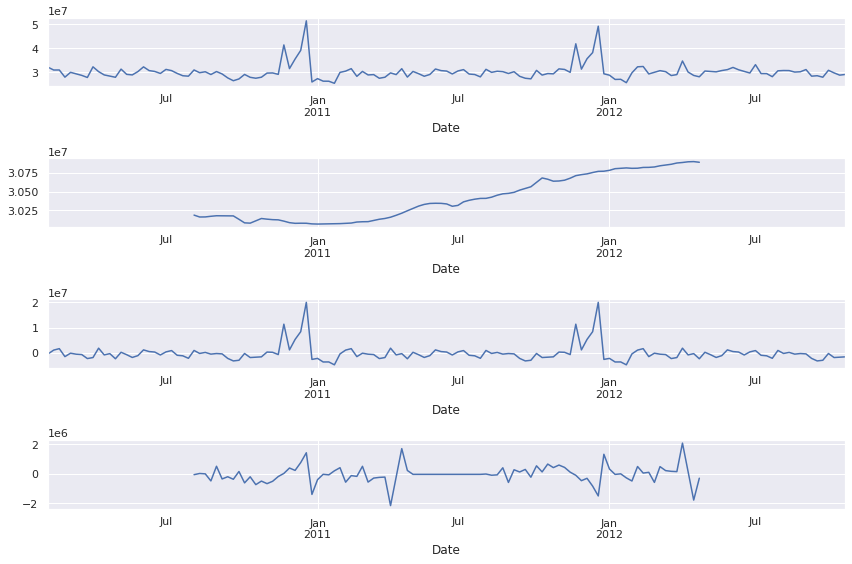

In [142]:
#-- ploting seasonal for stores A
result_a = seasonal_decompose(db_train_store_g[db_train_store_g['Type'] == 'A']['Weekly_Sales'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result_a.observed.plot(ax=ax1)
result_a.trend.plot(ax=ax2)
result_a.seasonal.plot(ax=ax3)
result_a.resid.plot(ax=ax4)
plt.tight_layout()

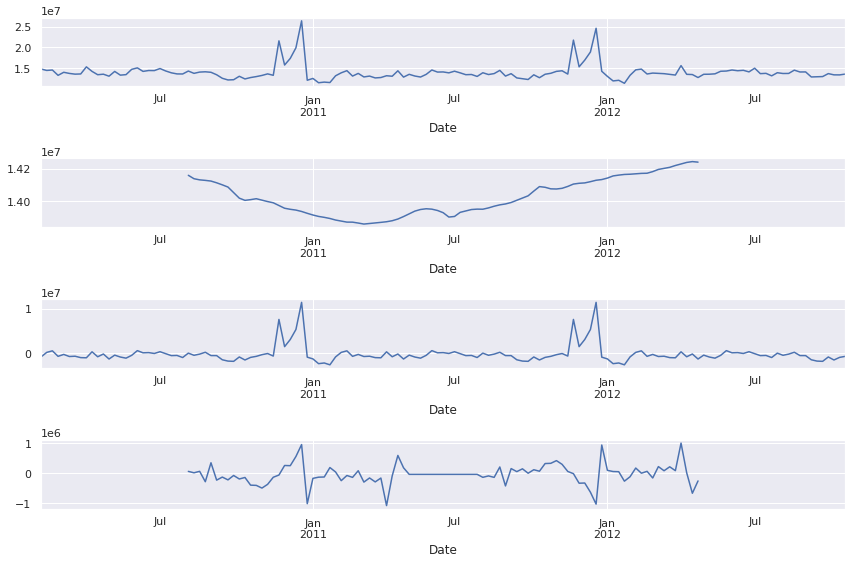

In [143]:
#-- ploting seasonal for stores B
result_b = seasonal_decompose(db_train_store_g[db_train_store_g['Type'] == 'B']['Weekly_Sales'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result_b.observed.plot(ax=ax1)
result_b.trend.plot(ax=ax2)
result_b.seasonal.plot(ax=ax3)
result_b.resid.plot(ax=ax4)
plt.tight_layout()

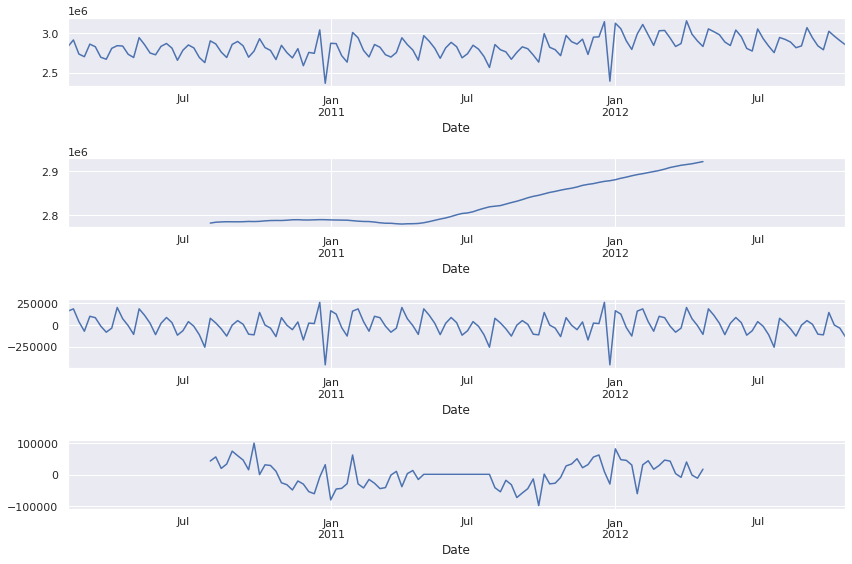

In [144]:
#-- ploting seasonal for stores C
result_c = seasonal_decompose(db_train_store_g[db_train_store_g['Type'] == 'C']['Weekly_Sales'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result_c.observed.plot(ax=ax1)
result_c.trend.plot(ax=ax2)
result_c.seasonal.plot(ax=ax3)
result_c.resid.plot(ax=ax4)
plt.tight_layout()

Analyzig the plots above, we can notice a difference in the total sell by store type. 
- All kind of stores presents a tendence to increase sales. 
- We can notice sazonality too, as black fridays and periods before Christmas.

In [145]:
#-- function to define stationarity
def estacionario(x):
    """Função para avaliar se os dados são estacionários"""
    
    if adfuller(x)[1] <= 0.05:
        print('Conjunto de dados é estacionário')
        print(f'Número de lags utilizado: {adfuller(x)[2]}')
    else:
        print('Conjuntos de dados não é estacionário')

In [146]:
#-- function to define normality
def normal(x):
    """Função para avaliar normalidade"""
    p_normal = stats.shapiro(x)[1]
    
    if p_normal >= 0.05:
        print(f'Dados seguem uma distribuição normal - p_value = {p_normal:.2}')
    else:
        print(f'Dados não seguem uma distribuição normal - p_value = {p_normal:.2}')

> Irei testar se os dados são estacionários

In [147]:
#-- stationarity test
estacionario(db_train_store_g[db_train_store_g['Type'] == 'A']['Weekly_Sales'])

Conjunto de dados é estacionário
Número de lags utilizado: 4


In [148]:
#-- stationarity test
estacionario(db_train_store_g[db_train_store_g['Type'] == 'B']['Weekly_Sales'])

Conjunto de dados é estacionário
Número de lags utilizado: 4


In [149]:
#-- stationarity test
estacionario(db_train_store_g[db_train_store_g['Type'] == 'C']['Weekly_Sales'])

Conjuntos de dados não é estacionário


- Only C stores are not stacionary. This is important if I'll use ARIMA's model.

> I'll test normality into the data

In [150]:
#-- normality teste
normal(db_train_store_g[db_train_store_g['Type'] == 'A']['Weekly_Sales'])

Dados não seguem uma distribuição normal - p_value = 7.9e-17


In [151]:
#-- normality teste
normal(db_train_store_g[db_train_store_g['Type'] == 'B']['Weekly_Sales'])

Dados não seguem uma distribuição normal - p_value = 9.1e-18


In [152]:
#-- normality teste
normal(db_train_store_g[db_train_store_g['Type'] == 'C']['Weekly_Sales'])

Dados não seguem uma distribuição normal - p_value = 0.038


The databases are not normal, so I can not calculate confidential interval.

## Merging dbs

In [153]:
#-- merging train_stores + features
db_train_store_features = pd.merge(left=db_train_store, right=db_features, on=['Store', 'Date'], how='left', suffixes=('_train', '_features'))
db_train_store_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [154]:
db_train_store_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Store               421570 non-null  int64         
 1   Dept                421570 non-null  int64         
 2   Date                421570 non-null  datetime64[ns]
 3   Weekly_Sales        421570 non-null  float64       
 4   IsHoliday_train     421570 non-null  bool          
 5   Type                421570 non-null  object        
 6   Size                421570 non-null  int64         
 7   Temperature         421570 non-null  float64       
 8   Fuel_Price          421570 non-null  float64       
 9   MarkDown1           150681 non-null  float64       
 10  MarkDown2           111248 non-null  float64       
 11  MarkDown3           137091 non-null  float64       
 12  MarkDown4           134967 non-null  float64       
 13  MarkDown5           151432 no

In [156]:
#-- creating db bi store type
type_a = db_train_store_features.loc[db_train_store_features['Type'] == 'A']
type_b = db_train_store_features.loc[db_train_store_features['Type'] == 'B']
type_c = db_train_store_features.loc[db_train_store_features['Type'] == 'C']

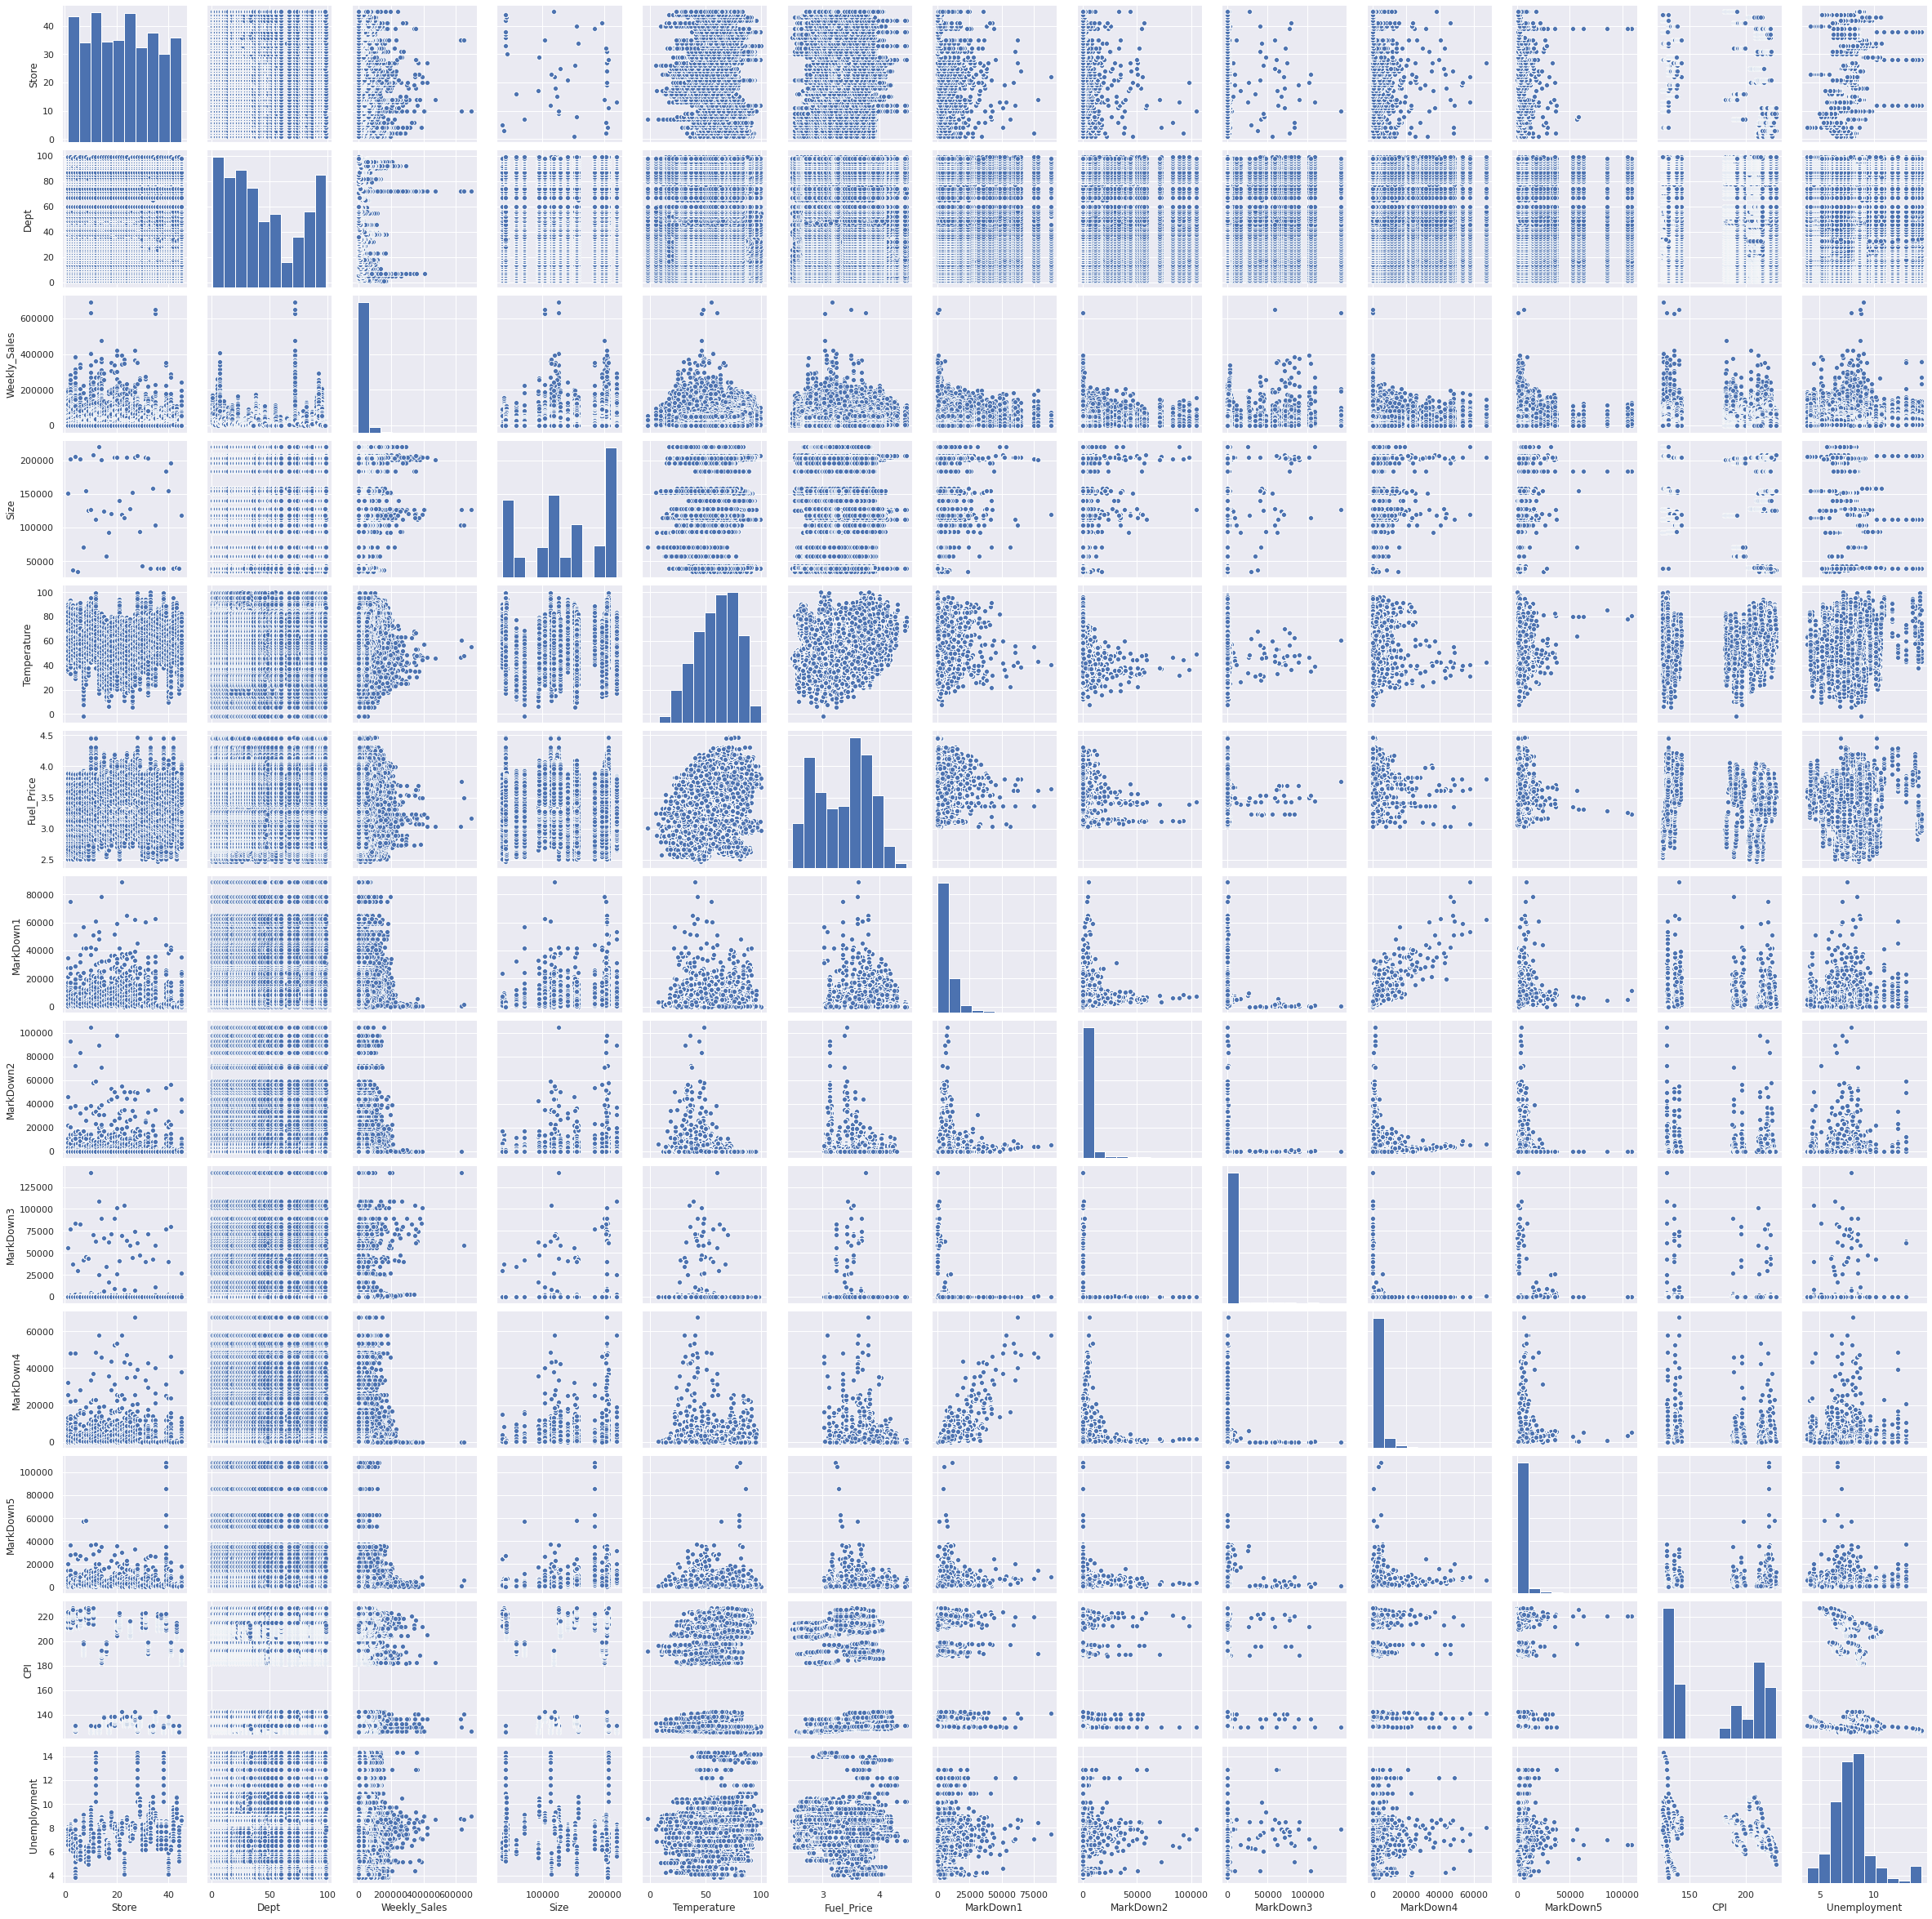

In [157]:
#-- EDA
_ = sns.pairplot(db_train_store_features_n)

With the figure above, it is possible to verify:
- some unmployment rate has more weekly sales, temperature and store size

<Figure size 792x1080 with 0 Axes>

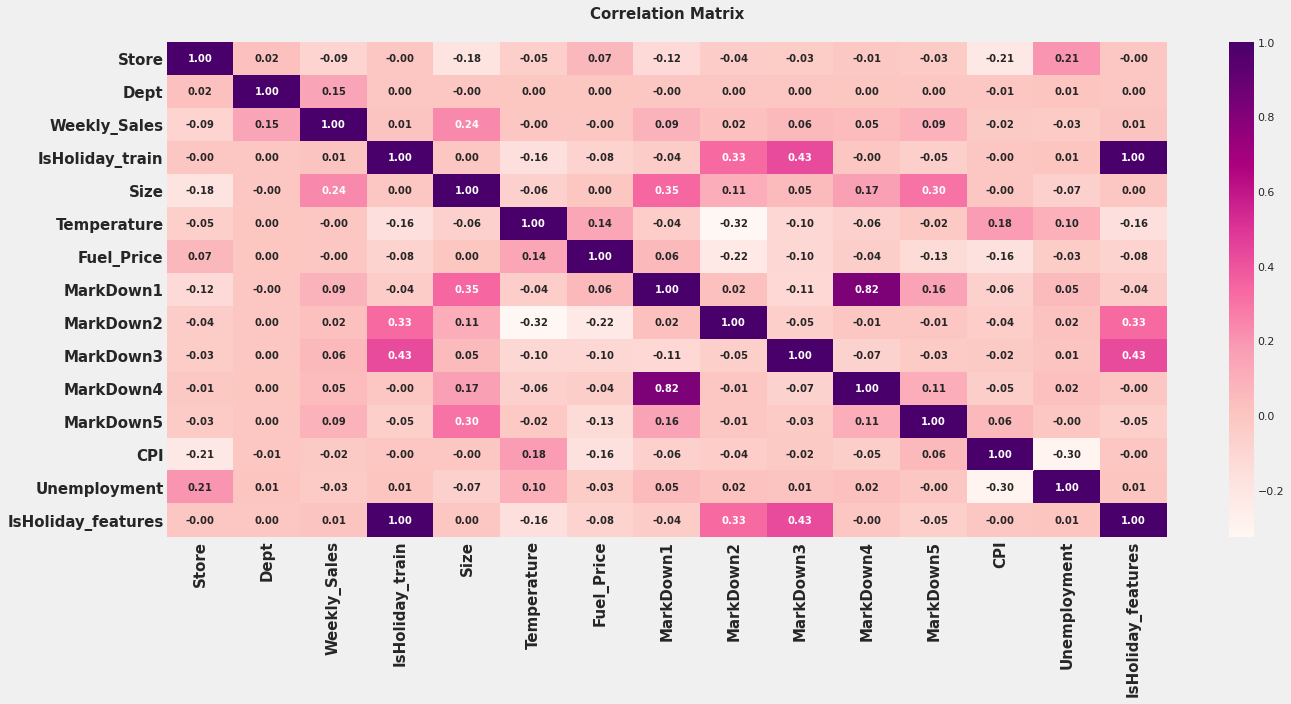

In [158]:
#-- checking correlation between features
_ = plt.clf()
_ = plt.style.use('fivethirtyeight')
_ = font_opts = {'fontsize':15, 'fontweight':'bold'}
_ = plt.figure(figsize=(20,10))

x = sns.heatmap(
    db_train_store_features.corr(), 
    annot=db_train_store_features.corr(), 
    fmt='.2f', 
    annot_kws={'fontsize':10, 'fontweight':'bold'},
    cmap='RdPu'
)

_ = plt.title("Correlation Matrix\n", **font_opts)
_ = plt.xticks(**font_opts)
_ = plt.yticks(**font_opts)


_ = plt.tight_layout();
_ = plt.plot();

- Store size plays a little role in weekly sales

## MLI - BaseLine

- The data set has missing values and I didn't test for outliers (due to restrict time to solve this case). So, I'm gonna use random forest model, because it is not affect by those issues.

In [159]:
#-- converting strings to number
db_train_store_features.Type = db_train_store_features.Type.map({'A':1, 'B':2, 'C':3})

In [196]:
#-- selecting features
X_train = db_train_store_features[['Store','Dept','IsHoliday_train','Size', 'Type']]
Y_train = db_train_store_features['Weekly_Sales']

In [200]:
#-- creating function to ml
def random_forest(n_estimators, max_depth):
    resultado = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)
                ml_rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth, random_state=0)
                ml_rf.fit(x_train, y_train)
                predicted = ml_rf.predict(x_test)
                wmaes.append(wmae(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes))
            resultado.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes)})
    return pd.DataFrame(resultado)

In [201]:
#-- creating fuction to calculate error
def wmae(db, y, y_h):
    weights = db.IsHoliday_train.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(y-y_h))/(np.sum(weights)), 2)

In [202]:
#-- applying ml
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 3060.89
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 3060.89
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 3060.89
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 3060.19
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 3060.19
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 , max_depth: 30
k: 4 , n_e

,Max_Depth,Estimators,WMAE
0,25,56,3060.89
1,27,56,3060.89
2,30,56,3060.89
3,25,58,3060.19
4,27,58,3060.19
5,30,58,3060.19
6,25,60,3060.77
7,27,60,3060.77
8,30,60,3060.77


### Feature engineering

In [203]:
#-- creating columns based on date, I'll test if those columns will improve models evaluation
db_train_store_features['week'] = db_train_store_features['Date'].dt.week
db_train_store_features['month'] = db_train_store_features['Date'].dt.month
db_train_store_features['day_year'] = db_train_store_features['Date'].dt.dayofyear

In [204]:
#-- selecting features
X_train = db_train_store_features[['Store','Dept','IsHoliday_train','Size', 'Type', 'week', 'month', 'day_year']]
Y_train = db_train_store_features['Weekly_Sales']

## MLII

In [205]:
#-- running second model
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1815.98
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1820.75
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1828.12
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1816.22
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1820.67
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 , max_depth: 30
k: 4 , n_e

,Max_Depth,Estimators,WMAE
0,25,56,1815.98
1,27,56,1820.75
2,30,56,1828.12
3,25,58,1816.22
4,27,58,1820.67
5,30,58,1827.69
6,25,60,1815.87
7,27,60,1820.24
8,30,60,1827.15


- This model, with featuring engineering was considered improved in comparison with first model. So, I'll use it.

In [206]:
#-- defining model to use in test db
ml_rf = RandomForestRegressor(n_estimators=60, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1, random_state=0)
ml_rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=60, random_state=0)

## Applying into test db

In [207]:
#-- printing head
db_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [208]:
#-- checking data
db_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2)
memory usage: 2.7 MB


In [209]:
#-- converting date field
db_test.Date = db_test.Date.apply(pd.to_datetime)

In [210]:
#-- checking convertion
db_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2)
memory usage: 2.7 MB


In [211]:
#-- merging db_train + db_store
db_train_store = pd.merge(left=db_train, right=db_stores, on='Store', how='left')
db_train_store.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [212]:
#-- merging dbs
db_test_store = pd.merge(left=db_test, right=db_stores, on='Store', how='left' )
db_test_store.head()

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-11-02,False,A,151315
1,1,1,2012-11-09,False,A,151315
2,1,1,2012-11-16,False,A,151315
3,1,1,2012-11-23,True,A,151315
4,1,1,2012-11-30,False,A,151315


In [213]:
#-- merging dbs
db_test_store_features = pd.merge(left=db_test_store, right=db_features, on=['Store', 'Date'], how='left', suffixes=('_train', '_features'))
db_test_store_features.head()

,Store,Dept,Date,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,False
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,False
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,True
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,False


In [214]:
#-- converting
db_test_store_features.Type = db_test_store_features.Type.map({'A':1, 'B':2, 'C':3})

In [215]:
#-- creating same features
db_test_store_features['week'] = db_test_store_features['Date'].dt.week
db_test_store_features['month'] = db_test_store_features['Date'].dt.month
db_test_store_features['day_year'] = db_test_store_features['Date'].dt.dayofyear

In [216]:
#-- selecting features
X_test = db_test_store_features[['Store','Dept','IsHoliday_train','Size', 'Type', 'week', 'month', 'day_year']]

In [217]:
#-- running prediction
predict = ml_rf.predict(X_test)

In [218]:
#-- print prediction
print(predict)

[36766.46443333 19297.05156944 19165.67854167 ...   819.32763897
   775.56856353   588.38586314]


### Creating file to save results

In [181]:
#-- concat store + dept + date
db_test_store_features['Id'] = db_test_store_features['Store'].astype(str) + '_' + db_test_store_features['Dept'].astype(str) + '_' + db_test_store_features['Date'].astype(str)

In [182]:
#-- concat ID + Prediction
db_Submission = pd.concat([db_test_store_features['Id'], pd.DataFrame(predict)], axis=1)
db_Submission.columns = ['Id', 'Weekly_Sales']

In [189]:
#-- saving results into .csv
db_Submission.to_csv('walmart_thiago_mauricio.csv', index=False)

## Conclusions
1. some unmployment rate has more weekly sales, temperature and store size
2. store size has a little influence in weekly sales
3. week, month and day of the year have a strong impact in model's prediction

## Next steps
1. Fill missing values
2. User more featuring engineering as: difference between weekly sales and moving average
3. Use cross validation
4. Calculate feature importance
5. Test a different algorithm
6. Test splitting data by Store Type (A, B and C) 